# Bike sharing Assignment


<b>Business Goal</b>: Derive the model which will help to understand the demand

## 1) Data understanding and Visualisation

In [800]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [801]:
day = pd.read_csv("day.csv")

In [802]:
day.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [803]:
day.shape

(730, 16)

In [804]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [805]:
day.describe()

instant      season          yr        mnth     holiday     weekday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean   365.500000    2.498630    0.500000    6.526027    0.028767    2.997260   
std    210.877136    1.110184    0.500343    3.450215    0.167266    2.006161   
min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
25%    183.250000    2.000000    0.000000    4.000000    0.000000    1.000000   
50%    365.500000    3.000000    0.500000    7.000000    0.000000    3.000000   
75%    547.750000    3.000000    1.000000   10.000000    0.000000    5.000000   
max    730.000000    4.000000    1.000000   12.000000    1.000000    6.000000   

       workingday  weathersit        temp       atemp         hum   windspeed  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.683562    1.394521   20.319259   23.726322   62.765175   12.763620   
std      0.465405    0.544807    7.506729    8.150308   14.237589    5.195841   
min      0.000000    1.000000    2.424346    3.953480    0.000000    1.500244   
25%      0.000000    1.000000   13.811885   16.889713   52.000000    9.041650   
50%      1.000000    1.000000   20.465826   24.368225   62.625000   12.125325   
75%      1.000000    2.000000   26.880615   30.445775   72.989575   15.625589   
max      1.000000    3.000000   35.328347   42.044800   97.250000   34.000021   

            casual   registered          cnt  
count   730.000000   730.000000   730.000000  
mean    849.249315  3658.757534  4508.006849  
std     686.479875  1559.758728  1936.011647  
min       2.000000    20.000000    22.000000  
25%     316.250000  2502.250000  3169.750000  
50%     717.000000  3664.500000  4548.500000  
75%    1096.500000  4783.250000  5966.000000  
max    3410.000000  6946.000000  8714.000000

In [806]:
day.isnull().sum()#no null values in any of the columns

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>Categorical variables - yr,mnth,holiday,weekday,workingday,weathersit</li>
    <li>Continuous variables - temp,atemp,hum,windspeed,casual,registered,cnt</li>
    <li>instant,dteday,registered,casual are not necessary for our analysis</li>
    <li>weathersit and season are categorical column so we will assign names to categories</li>
</ul>

In [807]:
#Let's remove unnecessary columns
day.drop(columns=['instant','dteday','registered','casual'],axis=1,inplace=True)

In [808]:
# naming season and weathersit
day.season = day.season.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
day.weathersit = day.weathersit.map({1:'clear', 2:'cloudy', 3:'snow', 4:'rain'})

### Univariate analysis

In [809]:
def univariate(clm): 
    plt.figure(figsize=(20, 12))
    plt.subplot(2,2,1)
    sns.distplot(day[clm])
    plt.subplot(2,2,2)
    sns.boxplot(day[clm].values)
    plt.show()

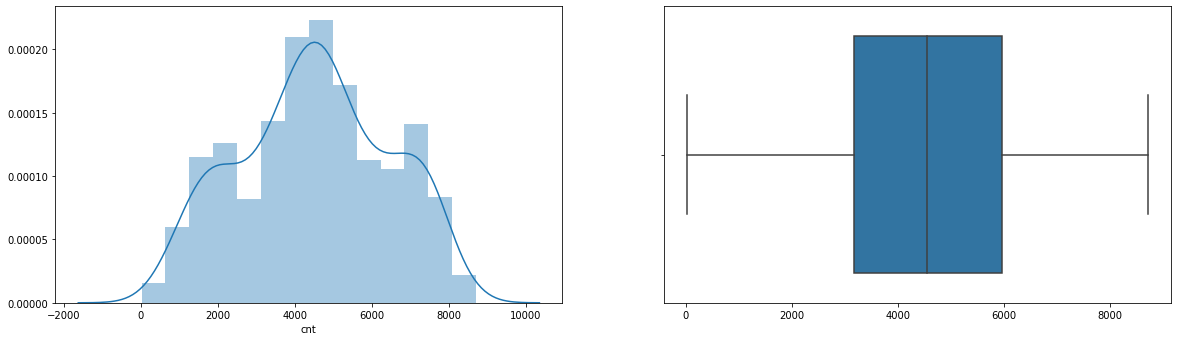

In [810]:
univariate('cnt')

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>count data is normally distributed</li>
    <li>Has no outliers</li>
    <li>Both the plots are statig median in between 4000 and 6000</li>
</ul>

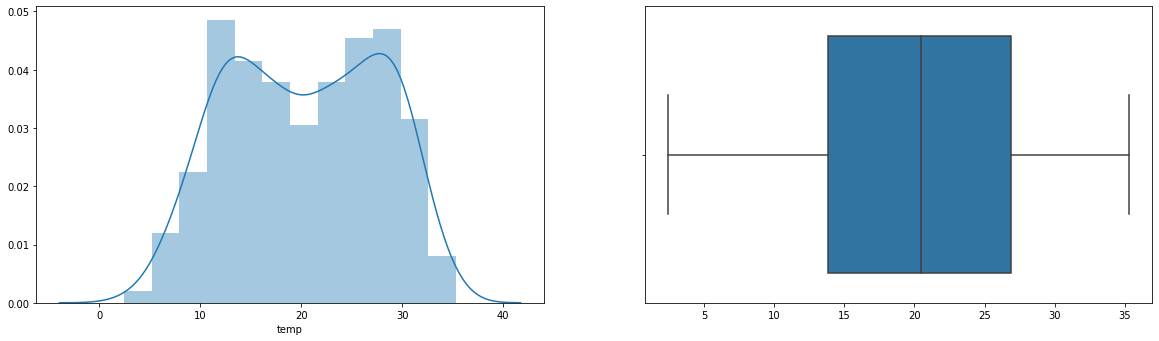

In [811]:
univariate('temp')

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>temp data is normally distributed</li>
    <li>Has no outliers</li>
    <li>Both the plots are statig median in between 20 and 25</li>
</ul>

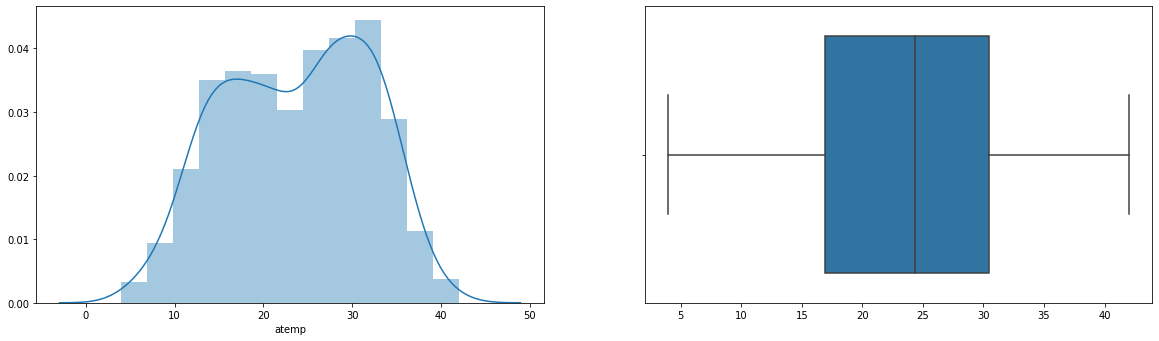

In [812]:
univariate('atemp')

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>atemp data is normally distributed</li>
    <li>Has no outliers</li>
    <li>Both the plots are statig median in between 20 and 25</li>
</ul>

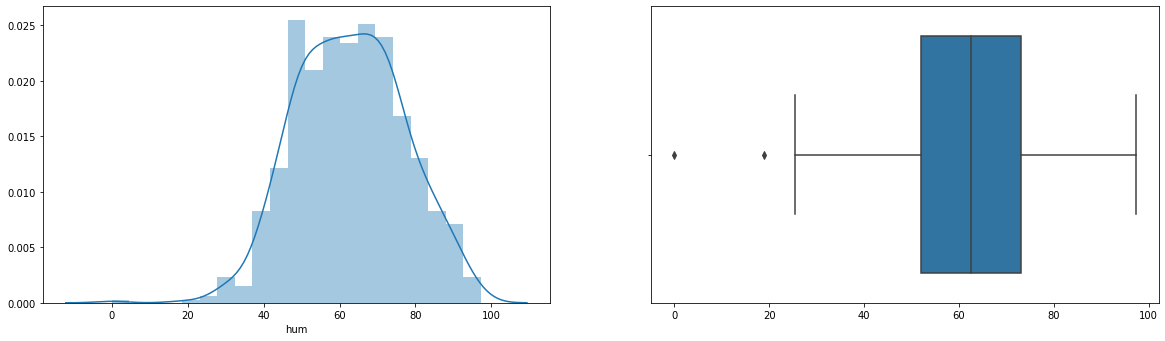

In [813]:
univariate('hum')

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>hum data is normally distributed</li>
    <li>Has outliers at lower end</li>
    <li>Both the plots are statig median in between 60 and 70</li>
</ul>

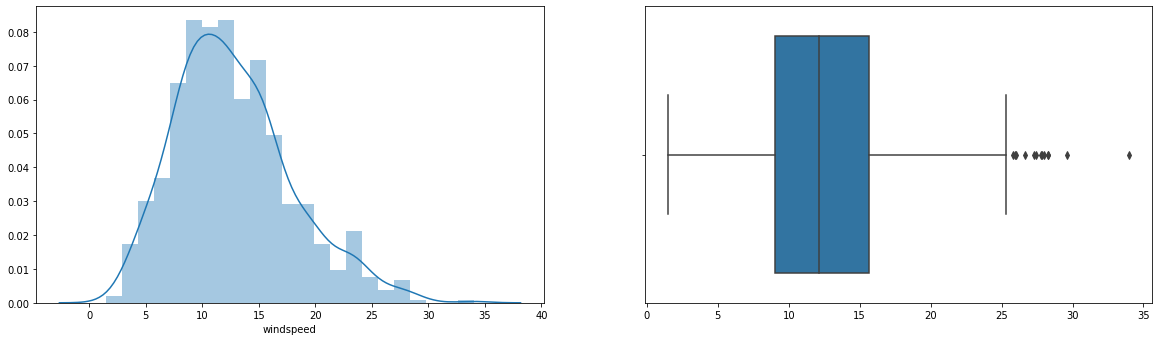

In [814]:
univariate('windspeed')

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>temp data is right skewed</li>
    <li>Has outliers on upper end</li>
    <li>Both the plots are statig median in between 10 and 15</li>
</ul>

### Multivariate analysis

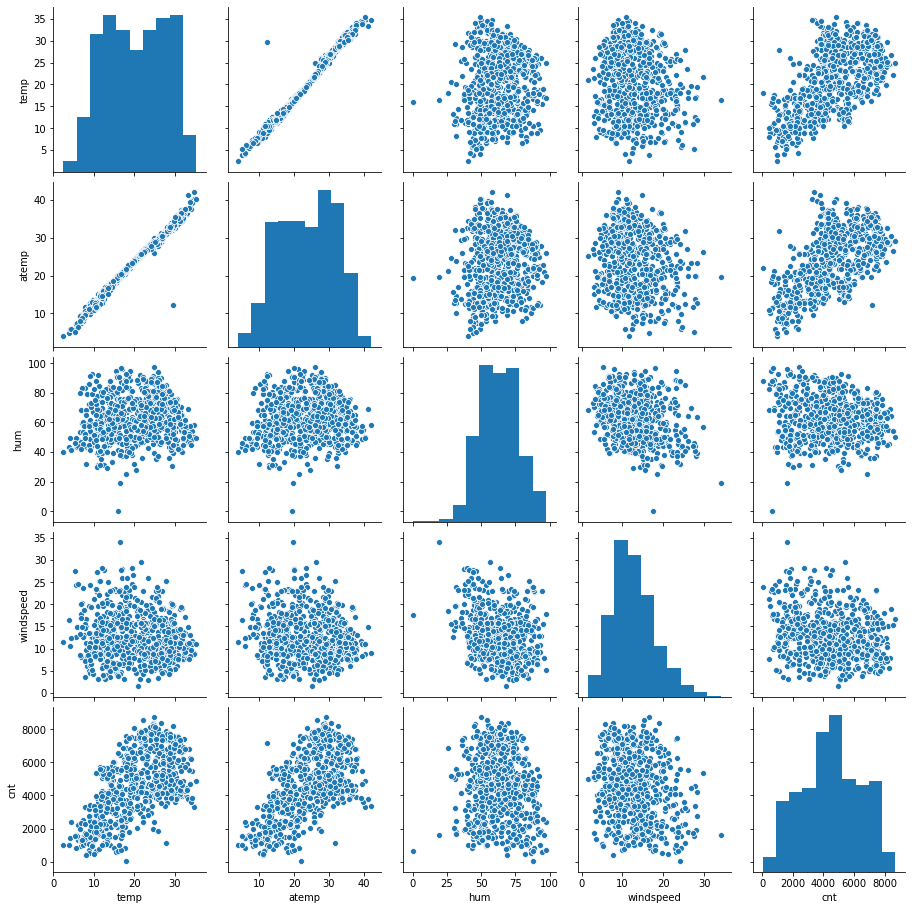

In [815]:
sns.pairplot(day[['temp','atemp','hum','windspeed','cnt']])

<b><font color='red'>[Insights]:-</font></b> 
    <ul>
        <li>hum and windspeed have little correlation with target variable</li>
        <li>temp and atemp are highly correlated to target variable</li>
    </ul>

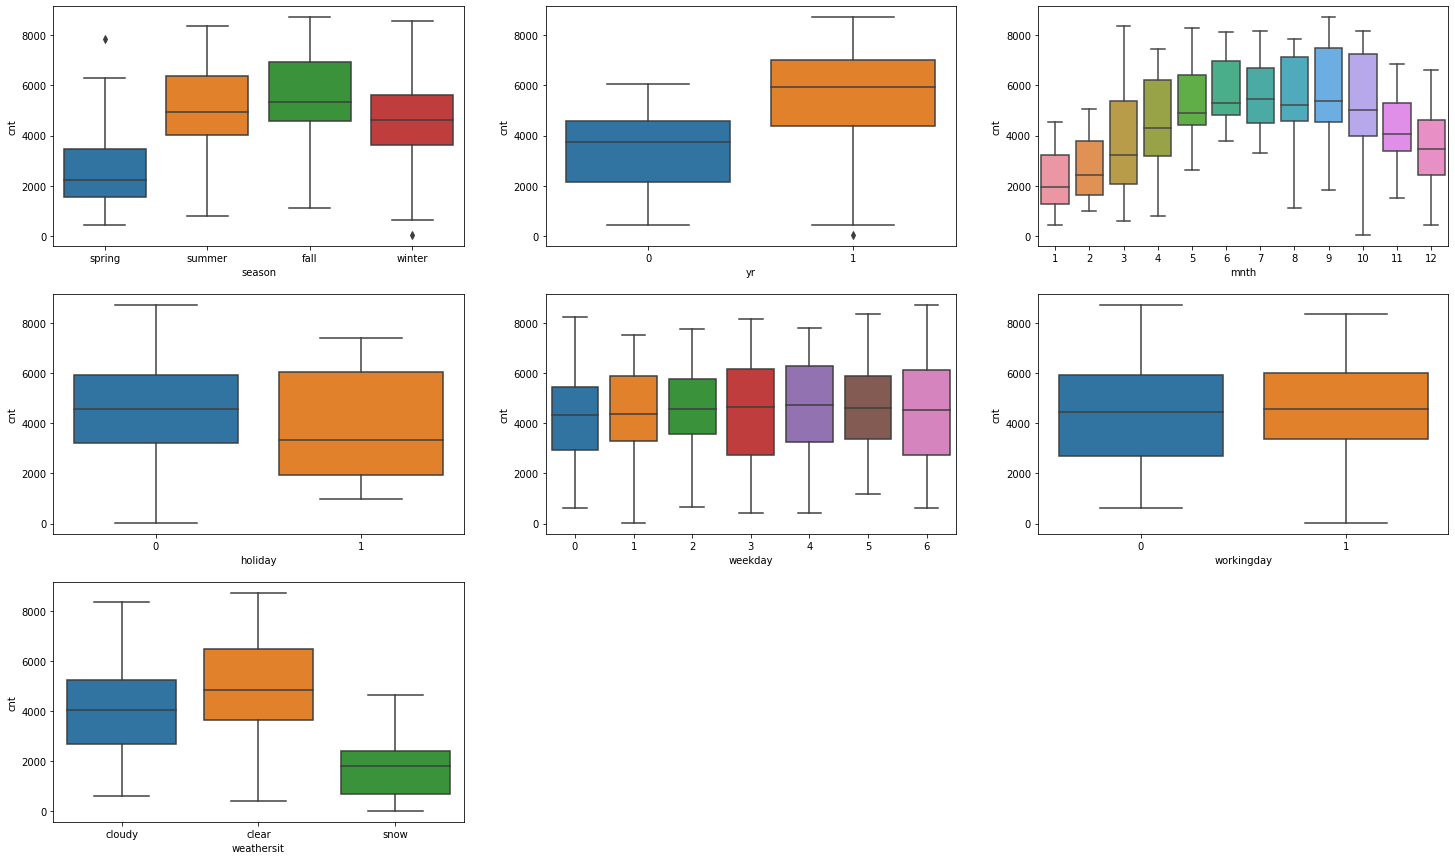

In [816]:
plt.figure(figsize=(25, 15))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = day)
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = day)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = day)
plt.subplot(3,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = day)
plt.subplot(3,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = day)
plt.subplot(3,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = day)
plt.subplot(3,3,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = day)

plt.show()

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>season,yr,mnth, weathersit have visible relationships with cnt variable</li>
    <li>All weekdays have similar median</li>
</ul>

### Let's confirm some of the analysis with heatmap

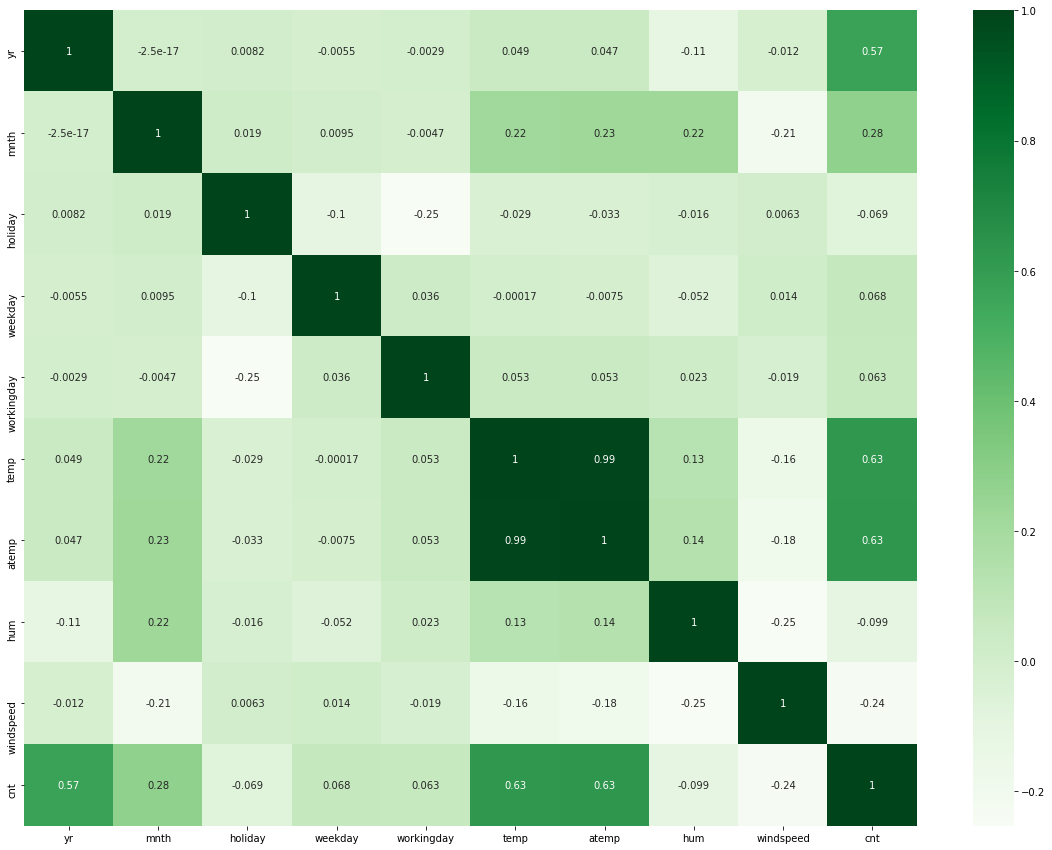

In [817]:
plt.figure(figsize=(20,15))
sns.heatmap(day.corr() ,annot=True, cmap='Greens')
plt.show()

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>We can see that temp and atemp have higher correlation</li>
</ul>

In [818]:
def bivariate(clm):
    day.groupby([clm])['cnt'].sum().plot.bar()
    plt.show()

In [819]:
bivariate('yr')

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>No of bikes rent count increses with passing year</li>
</ul>

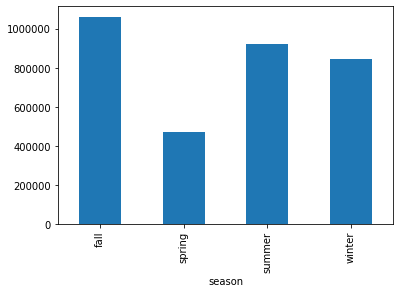

In [820]:
bivariate('season')

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>fall season has seen maximum number of rented bikes followed by summer and winter</li>
</ul>

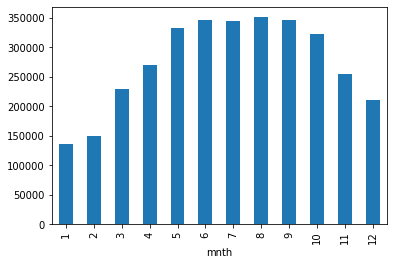

In [821]:
bivariate('mnth')

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>Demand is uniformly distributed across months</li>
</ul>

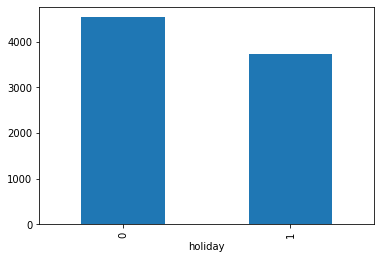

In [822]:
#we will take mean for holiday as no of holidays are less 
day.groupby(['holiday'])['cnt'].mean().plot.bar()
plt.show()

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>We can see that holidays can reduce the demand</li>
</ul>

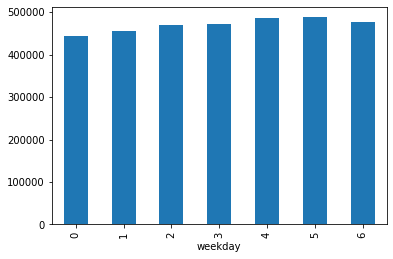

In [823]:
bivariate('weekday')

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>Monday has seen lowest number of rents</li>
</ul>

In [824]:
day.groupby(['workingday'])['cnt'].mean().plot.bar()
plt.show()

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>No visible insights</li>
</ul>

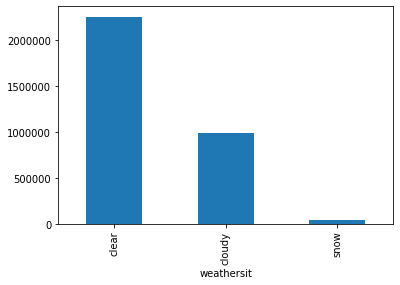

In [825]:
bivariate('weathersit')

<b> <font color='red'>[Insights] :-</font> </b>
<ul>
    <li>clear weather has seen highest demands</li>
</ul>

# Model number 1 

Dummy variables - season, weathersit

## Data preparation

### Dummy variables

In [826]:
day2 = day.copy(deep=True)
temp = pd.get_dummies(day[['season','weathersit']], drop_first = True)
day = pd.concat([day, temp], axis = 1)

In [827]:
#deleting unnecessary columns
#we will drop hum and windspeed as they have little correlation with target variable
day.drop(columns=['season','weathersit','atemp','hum','windspeed'],axis=1,inplace=True)

In [828]:
day.head()

yr  mnth  holiday  weekday  workingday       temp   cnt  season_spring  \
0   0     1        0        6           0  14.110847   985              1   
1   0     1        0        0           0  14.902598   801              1   
2   0     1        0        1           1   8.050924  1349              1   
3   0     1        0        2           1   8.200000  1562              1   
4   0     1        0        3           1   9.305237  1600              1   

   season_summer  season_winter  weathersit_cloudy  weathersit_snow  
0              0              0                  1                0  
1              0              0                  1                0  
2              0              0                  0                0  
3              0              0                  0                0  
4              0              0                  0                0

### Modeling

Spliting data into test and train

In [829]:
np.random.seed(0)
df_train, df_test = train_test_split(day, train_size = 0.7, test_size = 0.3, random_state = 100)

In [830]:
print(df_train.shape)
print(df_test.shape)

(510, 12)
(219, 12)


Scaling the data using MinMaxScalar

In [831]:
scaler = MinMaxScaler()

num_vars = ['temp','cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

yr  mnth  holiday  weekday  workingday      temp       cnt  \
653   1    10        0        2           1  0.509887  0.864243   
576   1     7        0        2           1  0.815169  0.827658   
426   1     3        0        6           0  0.442393  0.465255   
728   1    12        0        0           0  0.245101  0.204096   
482   1     4        0        6           0  0.395666  0.482973   

     season_spring  season_summer  season_winter  weathersit_cloudy  \
653              0              0              1                  0   
576              0              0              0                  0   
426              1              0              0                  1   
728              1              0              0                  0   
482              0              1              0                  1   

     weathersit_snow  
653                0  
576                0  
426                0  
728                0  
482                0

Let's check for colinearity between columns

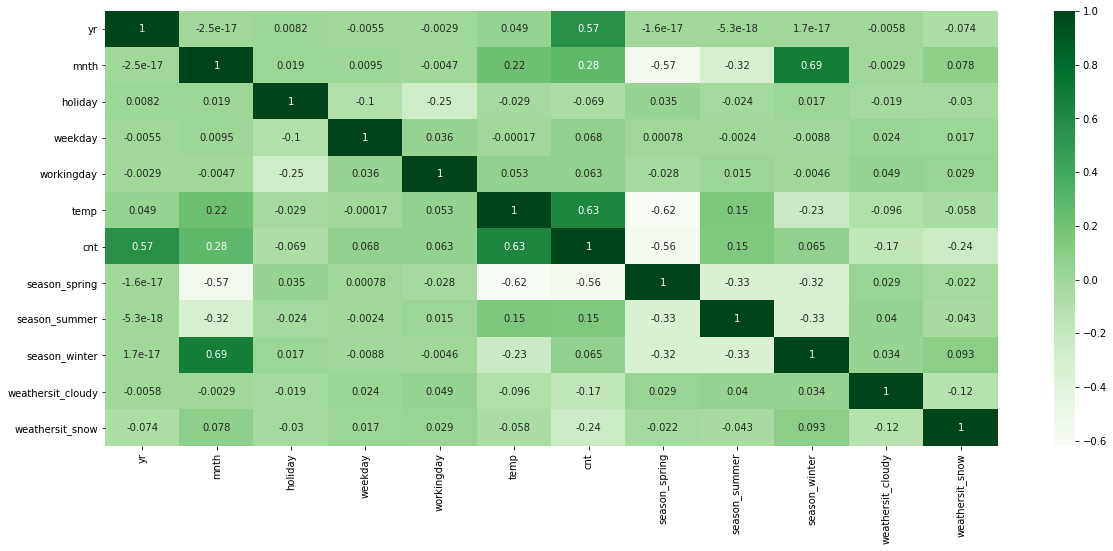

In [832]:
plt.figure(figsize=(20,8))
sns.heatmap(day.corr(), annot=True,cmap='Greens')
plt.show()

<b><font color='red'>[Insigths] :-</font></b>temp seems to be highly correlated to the cnt (our target variable), so we'll begin our analysis with temp

<b> Xtrain and ytrain 

In [833]:
#utility method for model building
def linear_model(clmns):
    y_train = df_train['cnt']
    X_train = df_train[clmns]
    X_train_sm = sm.add_constant(X_train)
    lr = sm.OLS(y_train,X_train_sm)
    lr_model = lr.fit()
    display(lr_model.summary())
    
    vif = pd.DataFrame()
    vif['Features'] = X_train_sm.columns
    vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    display(vif)

In [834]:
linear_model(['temp'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     359.1
Date:                Mon, 31 Aug 2020   Prob (F-statistic):           5.80e-61
Time:                        22:18:54   Log-Likelihood:                 174.84
No. Observations:                 510   AIC:                            -345.7
Df Residuals:                     508   BIC:                            -337.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1698      0.020      8.628      0.000       0.131       0.208
temp           0.6400      0.034     18.949      0.000       0.574       0.706
==============================================================================
Omnibus:                        6.280   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                4.555
Skew:                           0.098   Prob(JB):                        0.103
Kurtosis:                       2.580   Cond. No.                         5.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0    const  6.67
1     temp  1.00

<b><font color='red'>[Conclusion]</font></b>:- We can see that R square is quite ok, let's see whether we can do better than this. Let's add more variable (2nd highest correlated variable - yr )

In [835]:
linear_model(['temp','yr'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     564.9
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          9.25e-130
Time:                        22:18:54   Log-Likelihood:                 337.38
No. Observations:                 510   AIC:                            -668.8
Df Residuals:                     507   BIC:                            -656.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0796      0.015      5.331      0.000       0.050       0.109
temp           0.5836      0.025     23.604      0.000       0.535       0.632
yr             0.2372      0.011     21.261      0.000       0.215       0.259
==============================================================================
Omnibus:                       31.402   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.724
Skew:                          -0.503   Prob(JB):                     5.28e-10
Kurtosis:                       4.000   Cond. No.                         6.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0    const  7.26
1     temp  1.01
2       yr  1.01

<b><font color='red'>[Conclusion]</font></b>:- We can see that R square value increased significantly. Let's add more variables which are correlated

This time we'll add mnth

In [836]:
linear_model(['temp','yr','mnth'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     424.1
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          1.22e-137
Time:                        22:18:54   Log-Likelihood:                 359.00
No. Observations:                 510   AIC:                            -710.0
Df Residuals:                     506   BIC:                            -693.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0300      0.016      1.862      0.063      -0.002       0.062
temp           0.5438      0.024     22.238      0.000       0.496       0.592
yr             0.2403      0.011     22.429      0.000       0.219       0.261
mnth           0.0106      0.002      6.692      0.000       0.007       0.014
==============================================================================
Omnibus:                       74.760   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.873
Skew:                          -0.831   Prob(JB):                     7.76e-33
Kurtosis:                       5.049   Cond. No.                         37.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features   VIF
0    const  9.19
1     temp  1.08
3     mnth  1.06
2       yr  1.01

<b><font color='red'>[Conclusion]</font></b>:- R square increased

Now we will add categorical variables which have relations with cnt. ()

In [837]:
linear_model(['yr', 'mnth', 'temp',  'season_spring', 'season_summer', 'season_winter',
       'weathersit_cloudy', 'weathersit_snow','holiday','workingday'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     215.5
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          6.22e-174
Time:                        22:18:55   Log-Likelihood:                 464.63
No. Observations:                 510   AIC:                            -907.3
Df Residuals:                     499   BIC:                            -860.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1523      0.035      4.347      0.000       0.083       0.221
yr                    0.2327      0.009     26.409      0.000       0.215       0.250
mnth                  0.0010      0.002      0.392      0.695      -0.004       0.006
temp                  0.4763      0.035     13.573      0.000       0.407       0.545
season_spring        -0.0889      0.024     -3.707      0.000      -0.136      -0.042
season_summer         0.0285      0.016      1.775      0.076      -0.003       0.060
season_winter         0.0740      0.019      3.854      0.000       0.036       0.112
weathersit_cloudy    -0.0751      0.009     -8.051      0.000      -0.093      -0.057
weathersit_snow      -0.2958      0.026    -11.259      0.000      -0.347      -0.244
holiday              -0.0772      0.029     -2.704      0.007      -0.133      -0.021
workingday            0.0200      0.010      2.082      0.038       0.001       0.039
==============================================================================
Omnibus:                       62.708   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.902
Skew:                          -0.600   Prob(JB):                     2.85e-38
Kurtosis:                       5.588   Cond. No.                         92.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0               const  64.67
4       season_spring   5.58
2                mnth   3.86
6       season_winter   3.64
3                temp   3.30
5       season_summer   2.52
9             holiday   1.07
10         workingday   1.07
8     weathersit_snow   1.04
7   weathersit_cloudy   1.03
1                  yr   1.02

<b><font color='red'>[Conclusion]</font></b>:- We can see that R square increased but mnth column has higher p value so we'll remove it.

In [838]:
linear_model(['yr', 'temp',  'season_spring', 'season_summer', 'season_winter',
       'weathersit_cloudy', 'weathersit_snow','holiday','workingday'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     239.8
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          4.21e-175
Time:                        22:18:55   Log-Likelihood:                 464.56
No. Observations:                 510   AIC:                            -909.1
Df Residuals:                     500   BIC:                            -866.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1592      0.030      5.270      0.000       0.100       0.219
yr                    0.2325      0.009     26.449      0.000       0.215       0.250
temp                  0.4772      0.035     13.640      0.000       0.409       0.546
season_spring        -0.0931      0.021     -4.347      0.000      -0.135      -0.051
season_summer         0.0257      0.014      1.794      0.073      -0.002       0.054
season_winter         0.0772      0.017      4.451      0.000       0.043       0.111
weathersit_cloudy    -0.0751      0.009     -8.057      0.000      -0.093      -0.057
weathersit_snow      -0.2961      0.026    -11.278      0.000      -0.348      -0.244
holiday              -0.0768      0.029     -2.695      0.007      -0.133      -0.021
workingday            0.0199      0.010      2.074      0.039       0.001       0.039
==============================================================================
Omnibus:                       62.444   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.077
Skew:                          -0.597   Prob(JB):                     4.31e-38
Kurtosis:                       5.583   Cond. No.                         18.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0              const  48.19
3      season_spring   4.46
2               temp   3.29
5      season_winter   2.97
4      season_summer   2.00
8            holiday   1.07
9         workingday   1.07
7    weathersit_snow   1.04
6  weathersit_cloudy   1.03
1                 yr   1.02

<b><font color='red'>[Conclusion]</font></b>:- Still spring_summer has higher p value(>5%) we'll remove that as well

In [839]:
linear_model(['yr', 'temp',  'season_spring', 'season_winter',
       'weathersit_cloudy', 'weathersit_snow','holiday','workingday'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     268.2
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          1.23e-175
Time:                        22:18:55   Log-Likelihood:                 462.92
No. Observations:                 510   AIC:                            -907.8
Df Residuals:                     501   BIC:                            -869.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1938      0.023      8.320      0.000       0.148       0.240
yr                    0.2332      0.009     26.488      0.000       0.216       0.250
temp                  0.4448      0.030     14.815      0.000       0.386       0.504
season_spring        -0.1185      0.016     -7.346      0.000      -0.150      -0.087
season_winter         0.0568      0.013      4.331      0.000       0.031       0.083
weathersit_cloudy    -0.0749      0.009     -8.016      0.000      -0.093      -0.057
weathersit_snow      -0.2973      0.026    -11.304      0.000      -0.349      -0.246
holiday              -0.0778      0.029     -2.723      0.007      -0.134      -0.022
workingday            0.0199      0.010      2.072      0.039       0.001       0.039
==============================================================================
Omnibus:                       62.692   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.743
Skew:                          -0.596   Prob(JB):                     1.14e-38
Kurtosis:                       5.608   Cond. No.                         14.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0              const  28.53
3      season_spring   2.52
2               temp   2.41
4      season_winter   1.69
7            holiday   1.07
8         workingday   1.07
6    weathersit_snow   1.04
5  weathersit_cloudy   1.03
1                 yr   1.02

<b><font color='red'>[Conclusion]</font></b>:- Now we have model which has optimum R square and significant p values

Before finaling this mode let's see VIF values for all features and remove features which have high VIF (for our analysis we'll take threshold of 5)

<b><font color='red'>[Conclusion]</font></b>:- No feature as VIF higher than 5, So we can finalize our model

### Residual analysis

In [840]:
y_train = df_train['cnt']
X_train = df_train[['yr', 'temp',  'season_spring', 'season_winter',
       'weathersit_cloudy', 'weathersit_snow','holiday','workingday']]
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()

In [841]:
y_train_pred = lr_model.predict(X_train_sm)

Text(0.5, 0, 'Errors')

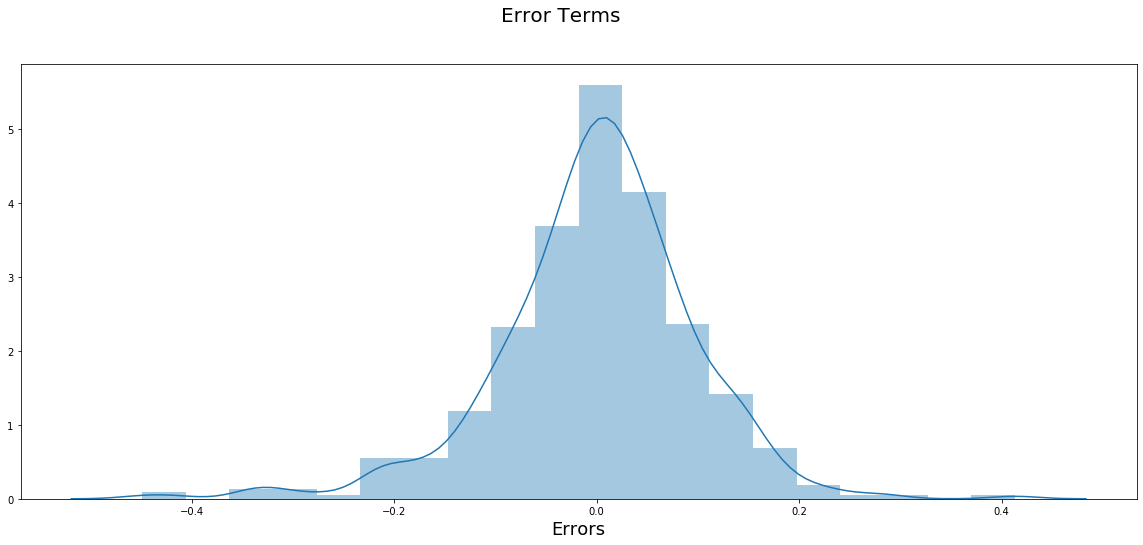

In [842]:
res = (y_train - y_train_pred)
fig = plt.figure(figsize=(20,8))
sns.distplot(res, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)    

<b><font color='red'>[Conclusion]</font></b>:- We can see normal distribution for residual, so first condition satisfied.

### Testing the model with Test data

In [843]:
num_vars = ['temp','cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

yr  mnth  holiday  weekday  workingday      temp       cnt  \
184   0     7        1        1           0  0.831783  0.692706   
535   1     6        0        3           1  0.901354  0.712034   
299   0    10        0        4           1  0.511964  0.303382   
221   0     8        0        3           1  0.881625  0.547400   
152   0     6        0        4           1  0.817246  0.569029   

     season_spring  season_summer  season_winter  weathersit_cloudy  \
184              0              0              0                  1   
535              0              1              0                  0   
299              0              0              1                  1   
221              0              0              0                  0   
152              0              1              0                  0   

     weathersit_snow  
184                0  
535                0  
299                0  
221                0  
152                0

In [844]:
y_test = df_test['cnt']
X_test = df_test[['yr', 'temp',  'season_spring', 'season_winter',
       'weathersit_cloudy', 'weathersit_snow','holiday','workingday']]
X_test_sm = sm.add_constant(X_test)
lr = sm.OLS(y_test,X_test_sm)
lr_model = lr.fit()
display(lr_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     114.9
Date:                Mon, 31 Aug 2020   Prob (F-statistic):           2.19e-72
Time:                        22:18:55   Log-Likelihood:                 207.10
No. Observations:                 219   AIC:                            -396.2
Df Residuals:                     210   BIC:                            -365.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2369      0.036      6.640      0.000       0.167       0.307
yr                    0.2436      0.013     18.401      0.000       0.218       0.270
temp                  0.3916      0.046      8.528      0.000       0.301       0.482
season_spring        -0.1583      0.025     -6.258      0.000      -0.208      -0.108
season_winter         0.0576      0.020      2.831      0.005       0.018       0.098
weathersit_cloudy    -0.0618      0.014     -4.361      0.000      -0.090      -0.034
weathersit_snow      -0.2444      0.041     -6.004      0.000      -0.325      -0.164
holiday              -0.0675      0.036     -1.858      0.065      -0.139       0.004
workingday            0.0056      0.015      0.368      0.713      -0.024       0.035
==============================================================================
Omnibus:                       19.352   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.563
Skew:                          -0.641   Prob(JB):                     7.64e-06
Kurtosis:                       3.968   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [845]:
# r2 for test
y_pred = lr_model.predict(X_test_sm)
print(r2_score(y_test, y_pred))

0.8140092910643068


## So R squared for the test data is 0.800, which is closer to what we got for train data. This suggests that our model is stable.

Conclusions - 
<ul>
<li>Year has high correlation with no of bikes rent, which suggests that company can expect higher no of rental demands by     passing year.</li>
<li>We can see that as temp increases no of bikes rent also increases but till 20-30 range. So company can expect higher demand is temp is in between 10 - 30 range. Which can be shown in below plot</li>
   
</ul>

        

In [846]:
slot=['0-10','10-20','20-30','30-40']
bins=[0,10,20,30,40]
day['temp_range']=pd.cut(day.temp,bins,labels=slot)
sns.barplot(x='temp_range',y='cnt',data=day)

<ul>
<li> In addition to this weathersit_cloudy, weathersit_snow have negative correlation which suggest decrease in demand in these three scenarios.</li>
    <li> Holiday can impact deamnds of bike to rent negatively</li>
    </ul>

# Model 2 -

dummy variables - 'season','mnth','weekday','weathersit'

In [847]:
day2.mnth = day2.mnth.map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
day2.weekday = day2.weekday.map({0:'Mon',1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})


In [848]:
temp = pd.get_dummies(day2[['season','mnth','weekday','weathersit']], drop_first = True)
day2 = pd.concat([day2, temp], axis = 1)

In [849]:
day2.drop(columns=['season','weathersit','atemp','hum','windspeed','mnth','weekday'],axis=1,inplace=True)
day2.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'cnt', 'season_spring',
       'season_summer', 'season_winter', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb',
       'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar', 'mnth_May', 'mnth_Nov',
       'mnth_Oct', 'mnth_Sep', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'weathersit_cloudy',
       'weathersit_snow'],
      dtype='object')

In [850]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(day2, train_size = 0.7, test_size = 0.3, random_state = 100)

In [851]:
scaler = MinMaxScaler()

num_vars = ['temp','cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

yr  holiday  workingday      temp       cnt  season_spring  \
653   1        0           1  0.509887  0.864243              0   
576   1        0           1  0.815169  0.827658              0   
426   1        0           0  0.442393  0.465255              1   
728   1        0           0  0.245101  0.204096              1   
482   1        0           0  0.395666  0.482973              0   

     season_summer  season_winter  mnth_Aug  mnth_Dec  ...  mnth_Oct  \
653              0              1         0         0  ...         1   
576              0              0         0         0  ...         0   
426              0              0         0         0  ...         0   
728              0              0         0         1  ...         0   
482              1              0         0         0  ...         0   

     mnth_Sep  weekday_Mon  weekday_Sat  weekday_Sun  weekday_Thu  \
653         0            0            0            0            0   
576         0            0            0            0            0   
426         0            0            0            1            0   
728         0            1            0            0            0   
482         0            0            0            1            0   

     weekday_Tue  weekday_Wed  weathersit_cloudy  weathersit_snow  
653            0            1                  0                0  
576            0            1                  0                0  
426            0            0                  1                0  
728            0            0                  0                0  
482            0            0                  1                0  

[5 rows x 27 columns]

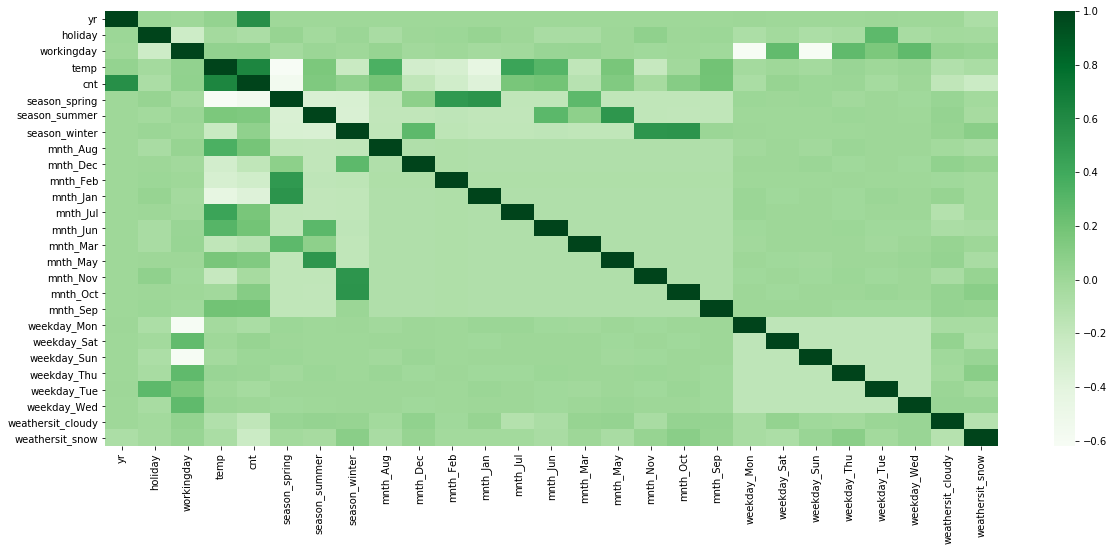

In [852]:
plt.figure(figsize=(20,8))
sns.heatmap(day2.corr(),cmap='Greens')
plt.show()

<b><font color='red'>[Note]</font></b> :- From above heatmap we can see that there are correlations between seasons and months, So ideally we need to drop any one of them but we won't do that rather we'll decide which factor to remove on the basis of VIF.

In [853]:
#utility method for model building
def linear_model2(clmns):
    y_train = df_train['cnt']
    X_train = df_train[clmns]
    X_train_sm = sm.add_constant(X_train)
    lr = sm.OLS(y_train,X_train_sm)
    lr_model = lr.fit()
    print(lr_model.summary())
    
    vif = pd.DataFrame()
    vif['Features'] = X_train_sm.columns
    vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    display(vif)

In [854]:
list_clms = list(day2.columns)
list_clms.remove('cnt')

## We'll be using RFE to select features 

In [855]:
def liner_rfe(clms):
    lm = LinearRegression()
    y_train = df_train['cnt']
    X_train = df_train[list_clms]
    lm.fit(X_train, y_train)
    rfe = RFE(lm, 10)             # running RFE
    rfe = rfe.fit(X_train, y_train)
    col = X_train.columns[rfe.support_]
    col
    X_train_rfe = X_train[col]
    X_train_rfe = sm.add_constant(X_train_rfe)
    lm = sm.OLS(y_train,X_train_rfe).fit() 
    display(lm.summary())
    
    vif = pd.DataFrame()
    vif['Features'] = X_train_rfe.columns
    vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    display(vif)
    print("Sel clms",list(col))
    

In [856]:
liner_rfe(list_clms)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     232.4
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          1.31e-180
Time:                        22:18:58   Log-Likelihood:                 480.40
No. Observations:                 510   AIC:                            -938.8
Df Residuals:                     499   BIC:                            -892.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1905      0.022      8.562      0.000       0.147       0.234
yr                    0.2334      0.009     27.357      0.000       0.217       0.250
holiday              -0.0983      0.027     -3.632      0.000      -0.152      -0.045
temp                  0.4724      0.031     15.111      0.000       0.411       0.534
season_spring        -0.1108      0.016     -7.065      0.000      -0.142      -0.080
season_winter         0.0556      0.013      4.383      0.000       0.031       0.081
mnth_Jul             -0.0692      0.018     -3.853      0.000      -0.105      -0.034
mnth_Sep              0.0656      0.016      4.036      0.000       0.034       0.098
weekday_Sun           0.0166      0.012      1.418      0.157      -0.006       0.040
weathersit_cloudy    -0.0797      0.009     -8.770      0.000      -0.097      -0.062
weathersit_snow      -0.3008      0.025    -11.801      0.000      -0.351      -0.251
==============================================================================
Omnibus:                       73.398   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                          -0.731   Prob(JB):                     4.47e-41
Kurtosis:                       5.570   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0               const  27.77
3                temp   2.79
4       season_spring   2.54
5       season_winter   1.69
6            mnth_Jul   1.28
7            mnth_Sep   1.10
9   weathersit_cloudy   1.04
10    weathersit_snow   1.04
1                  yr   1.02
2             holiday   1.02
8         weekday_Sun   1.01

Sel clms ['yr', 'holiday', 'temp', 'season_spring', 'season_winter', 'mnth_Jul', 'mnth_Sep', 'weekday_Sun', 'weathersit_cloudy', 'weathersit_snow']


<b><font color='red'>[Conclusion]</font></b>:- weekday_Sun has higher p value so we'll remove it 

In [857]:
list_clms.remove('weekday_Sun')
liner_rfe(list_clms)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     240.3
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          1.33e-183
Time:                        22:18:58   Log-Likelihood:                 487.47
No. Observations:                 510   AIC:                            -952.9
Df Residuals:                     499   BIC:                            -906.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2018      0.022      9.206      0.000       0.159       0.245
yr                    0.2329      0.008     27.697      0.000       0.216       0.249
holiday              -0.1088      0.027     -4.073      0.000      -0.161      -0.056
temp                  0.4698      0.031     15.244      0.000       0.409       0.530
season_spring        -0.1101      0.015     -7.119      0.000      -0.141      -0.080
season_winter         0.0579      0.013      4.622      0.000       0.033       0.082
mnth_Jul             -0.0664      0.018     -3.748      0.000      -0.101      -0.032
mnth_Sep              0.0645      0.016      4.022      0.000       0.033       0.096
weekday_Mon          -0.0480      0.012     -4.011      0.000      -0.072      -0.025
weathersit_cloudy    -0.0815      0.009     -9.087      0.000      -0.099      -0.064
weathersit_snow      -0.3055      0.025    -12.135      0.000      -0.355      -0.256
==============================================================================
Omnibus:                       69.452   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.780
Skew:                          -0.647   Prob(JB):                     9.27e-45
Kurtosis:                       5.805   Cond. No.                         13.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Features    VIF
0               const  27.69
3                temp   2.79
4       season_spring   2.54
5       season_winter   1.69
6            mnth_Jul   1.28
7            mnth_Sep   1.10
9   weathersit_cloudy   1.05
10    weathersit_snow   1.04
1                  yr   1.02
2             holiday   1.02
8         weekday_Mon   1.01

Sel clms ['yr', 'holiday', 'temp', 'season_spring', 'season_winter', 'mnth_Jul', 'mnth_Sep', 'weekday_Mon', 'weathersit_cloudy', 'weathersit_snow']


<b><font color='red'>[Conclusion]</font></b>:-Now we have created model using RFE which has optimum p value and moderate VIF 
for all the features. We'll going to fix this model and proceed with analysis

In [858]:
y_train = df_train['cnt']
X_train = df_train[list_clms]
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train,X_train_sm)
lr_model = lr.fit()

Text(0.5, 0, 'Errors')

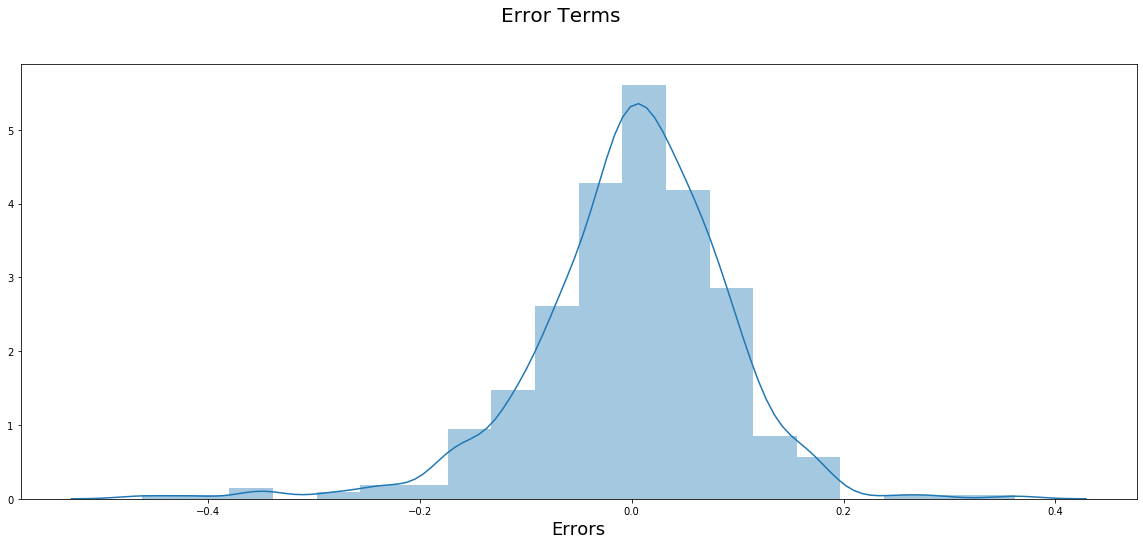

In [859]:
y_train_pred = lr_model.predict(X_train_sm)
res = (y_train - y_train_pred)
fig = plt.figure(figsize=(20,8))
sns.distplot(res, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)    

## Testing the model with test data

In [860]:
num_vars = ['temp','cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

yr  holiday  workingday      temp       cnt  season_spring  \
184   0        1           0  0.831783  0.692706              0   
535   1        0           1  0.901354  0.712034              0   
299   0        0           1  0.511964  0.303382              0   
221   0        0           1  0.881625  0.547400              0   
152   0        0           1  0.817246  0.569029              0   

     season_summer  season_winter  mnth_Aug  mnth_Dec  ...  mnth_Oct  \
184              0              0         0         0  ...         0   
535              1              0         0         0  ...         0   
299              0              1         0         0  ...         1   
221              0              0         1         0  ...         0   
152              1              0         0         0  ...         0   

     mnth_Sep  weekday_Mon  weekday_Sat  weekday_Sun  weekday_Thu  \
184         0            0            0            0            0   
535         0            0            0            0            1   
299         0            0            0            0            0   
221         0            0            0            0            1   
152         0            0            0            0            0   

     weekday_Tue  weekday_Wed  weathersit_cloudy  weathersit_snow  
184            1            0                  1                0  
535            0            0                  0                0  
299            0            0                  1                0  
221            0            0                  0                0  
152            0            0                  0                0  

[5 rows x 27 columns]

In [861]:
y_test = df_test['cnt']
X_test = df_test[['yr', 'holiday', 'temp', 'season_spring', 'season_winter', 'mnth_Jul', 'mnth_Sep', 'weekday_Mon', 'weathersit_cloudy', 'weathersit_snow']]
X_test_sm = sm.add_constant(X_test)
lr = sm.OLS(y_test,X_test_sm)
lr_model = lr.fit()
display(lr_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     95.89
Date:                Mon, 31 Aug 2020   Prob (F-statistic):           3.16e-72
Time:                        22:18:58   Log-Likelihood:                 211.75
No. Observations:                 219   AIC:                            -401.5
Df Residuals:                     208   BIC:                            -364.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2398      0.037      6.554      0.000       0.168       0.312
yr                    0.2432      0.013     18.730      0.000       0.218       0.269
holiday              -0.0677      0.034     -1.966      0.051      -0.136       0.000
temp                  0.4077      0.050      8.207      0.000       0.310       0.506
season_spring        -0.1553      0.025     -6.226      0.000      -0.204      -0.106
season_winter         0.0513      0.020      2.567      0.011       0.012       0.091
mnth_Jul             -0.0431      0.024     -1.759      0.080      -0.091       0.005
mnth_Sep              0.0383      0.024      1.591      0.113      -0.009       0.086
weekday_Mon          -0.0302      0.019     -1.631      0.104      -0.067       0.006
weathersit_cloudy    -0.0654      0.014     -4.681      0.000      -0.093      -0.038
weathersit_snow      -0.2543      0.040     -6.315      0.000      -0.334      -0.175
==============================================================================
Omnibus:                       19.386   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.846
Skew:                          -0.595   Prob(JB):                     2.44e-06
Kurtosis:                       4.191   Cond. No.                         14.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## So R squared for the test data is 0.822, which is closer to what we got for train data. This suggests that our model is stable.

In [862]:
# r2 for test
y_pred = lr_model.predict(X_test_sm)
print(r2_score(y_test, y_pred))

0.8217463794178496


## <font color='red'>Interpretations from the both the Models </font>

<ul>
    <li><b>Year</b> and <b>Temprature</b> have higher correlation with total count, this suggest that with increasing temprature and with passing year demand will going to increase.</li>
    <li>When we have bad weather such as <b>Light Snow, Light Rain, Thunderstorm ,Scattered clouds, Light Rain, Scattered clouds</b>, we can expect decrease in demand.</li>
    <li><b>Spring season</b> will attract less number of people to rent the bike.</li>
    <li><b>Holiday</b> can cause decrease in demand.</li>
    <li>Other features which are positively related with count - mnth_Sep, season_winter</li>
    <li>Other features which are negatively related with count - weekday_Mon, mnth_Jul</li>
</ul>